# Imigração do Brasil para o Canadá — Notebook Único (OK)

Este notebook consolida as análises e gera gráficos **embutidos** no arquivo.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LinearSegmentedColormap, Normalize
from pathlib import Path

# Cores
COR_BRASIL = "#1f77b4"
COR_MM5    = "#2ca02c"
COR_YOY    = "#17becf"
COR_PART   = "#9467bd"
COR_ACUM   = "#8c564b"
COR_INDICE = "#d62728"
COR_COMP_ARG = "#ff7f0e"
COR_COMP_CHN = "#e31a1c"
COR_COMP_IND = "#6a3d9a"
COR_HHI   = "#7f7f7f"

CORES_PAISES = {
    "Brazil": COR_BRASIL,
    "Argentina": COR_COMP_ARG,
    "China": COR_COMP_CHN,
    "India": COR_COMP_IND,
}

EXPORT_DIR = Path("./exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
DATA_CANDIDATES = [
    Path("imigrantes_canada.csv"),
    Path("./data/imigrantes_canada.csv"),
    Path("/mnt/data/imigrantes_canada.csv"),
]

def carregar_dados(candidates):
    path = None
    for p in candidates:
        if Path(p).exists():
            path = str(p)
            break
    if path is None:
        raise FileNotFoundError("Coloque 'imigrantes_canada.csv' na pasta do notebook.")
    encodings_to_try = [None, "utf-8", "latin1", "cp1252"]
    last_err=None; df=None
    for enc in encodings_to_try:
        try:
            df = pd.read_csv(path) if enc is None else pd.read_csv(path, encoding=enc)
            break
        except Exception as e:
            last_err=e; continue
    if df is None:
        raise last_err
    return df, path

def detectar_colunas(df):
    country_candidates = ["country", "país", "pais", "odname", "country_name", "country of birth", "country.of.birth"]
    country_col = None
    for cand in country_candidates:
        for c in df.columns:
            if str(c).lower() == cand:
                country_col = c; break
        if country_col: break
    if country_col is None:
        non_numeric_cols = [c for c in df.columns if not str(c).isdigit()]
        non_numeric_cols = [c for c in non_numeric_cols if str(c).lower() not in ["total"]]
        country_col = non_numeric_cols[0] if non_numeric_cols else df.columns[0]
    year_cols = [c for c in df.columns if str(c).isdigit() and 1900 <= int(str(c)) <= 2100]
    year_cols = sorted(year_cols, key=lambda x: int(x))
    years = [int(y) for y in year_cols]
    return country_col, year_cols, years

def obter_serie(df, country_col, year_cols, pais):
    cn = df[country_col].astype(str).str.strip().str.lower()
    alvo = pais.strip().lower()
    mask = cn.isin([alvo, "brazil" if alvo=="brasil" else "brasil"])
    sub = df.loc[mask]
    if sub.empty:
        sub = df.loc[cn.str.contains(alvo, na=False)]
    if sub.empty:
        raise ValueError(f"País '{pais}' não encontrado.")
    s = sub[year_cols].sum(axis=0)
    s.index = [int(x) for x in s.index]
    return s

In [4]:
df, caminho = carregar_dados(DATA_CANDIDATES)
country_col, year_cols, years = detectar_colunas(df)
br = obter_serie(df, country_col, year_cols, "Brazil")
total_by_year = df[year_cols].sum(axis=0); total_by_year.index = [int(x) for x in total_by_year.index]

brazil_df = pd.DataFrame({"Ano": [int(y) for y in year_cols], "Imigrantes": br.values.astype(int)}).sort_values("Ano")
brazil_df["MM5"] = brazil_df["Imigrantes"].rolling(5, min_periods=1).mean()
brazil_df["Participacao_%"] = (brazil_df["Imigrantes"].values / total_by_year.loc[brazil_df["Ano"]].values) * 100.0
brazil_df["YoY_Abs"] = brazil_df["Imigrantes"].diff()
base = brazil_df.loc[brazil_df["Imigrantes"].ne(0), "Imigrantes"].iloc[0] if (brazil_df["Imigrantes"] != 0).any() else 1.0
brazil_df["Indice_1980=100"] = (brazil_df["Imigrantes"]/base)*100.0
brazil_df["Acumulado"] = brazil_df["Imigrantes"].cumsum()

brazil_df.head()

,Ano,Imigrantes,MM5,Participacao_%,YoY_Abs,Indice_1980=100,Acumulado
0,1980,211,211.000000,0.212837,NaN,100.000000,211
1,1981,220,215.500000,0.198982,9.0,104.265403,431
2,1982,192,207.666667,0.184136,-28.0,90.995261,623
3,1983,139,190.500000,0.183984,-53.0,65.876777,762
4,1984,145,181.400000,0.197502,6.0,68.720379,907


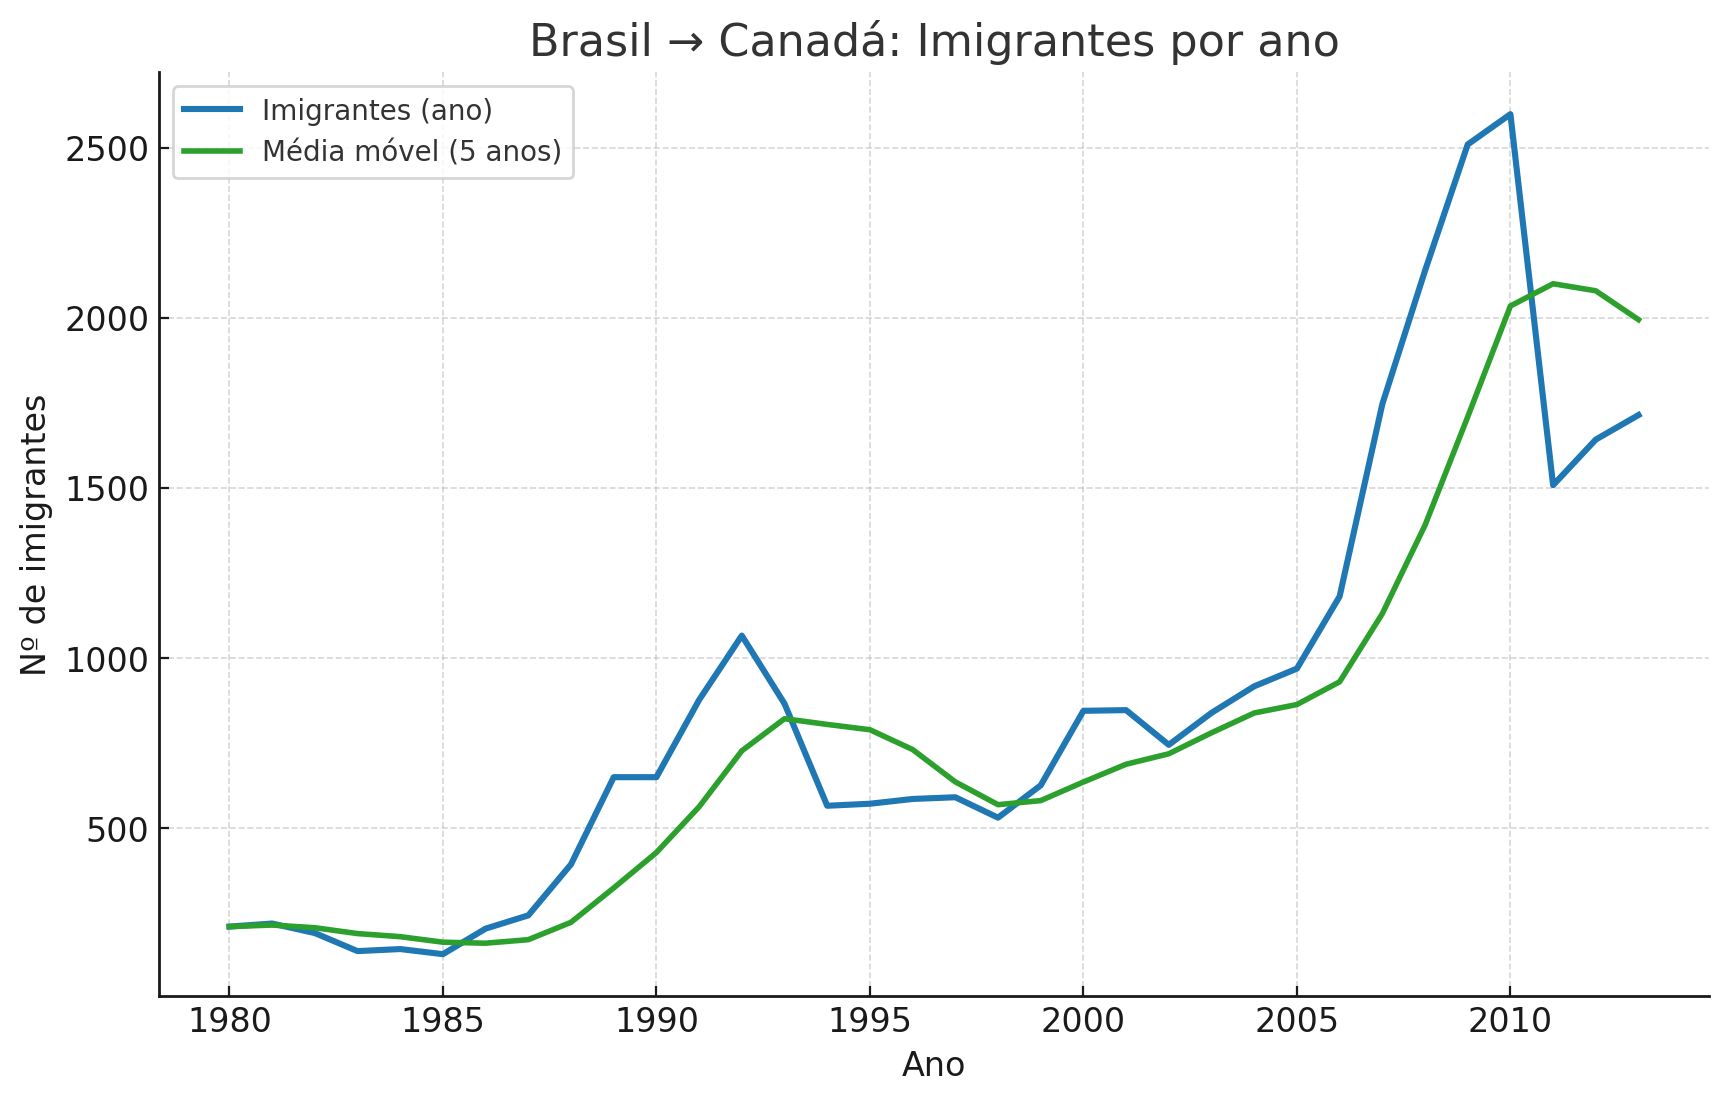

In [5]:
plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Imigrantes"], label="Imigrantes (ano)", color=COR_BRASIL, linewidth=2.2)
plt.plot(brazil_df["Ano"], brazil_df["MM5"], label="Média móvel (5 anos)", color=COR_MM5, linewidth=2.0)
plt.title("Brasil → Canadá: Imigrantes por ano")
plt.xlabel("Ano"); plt.ylabel("Nº de imigrantes"); plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
plt.savefig(EXPORT_DIR / "01_brasil_imigrantes_por_ano.png", bbox_inches="tight")
plt.show()

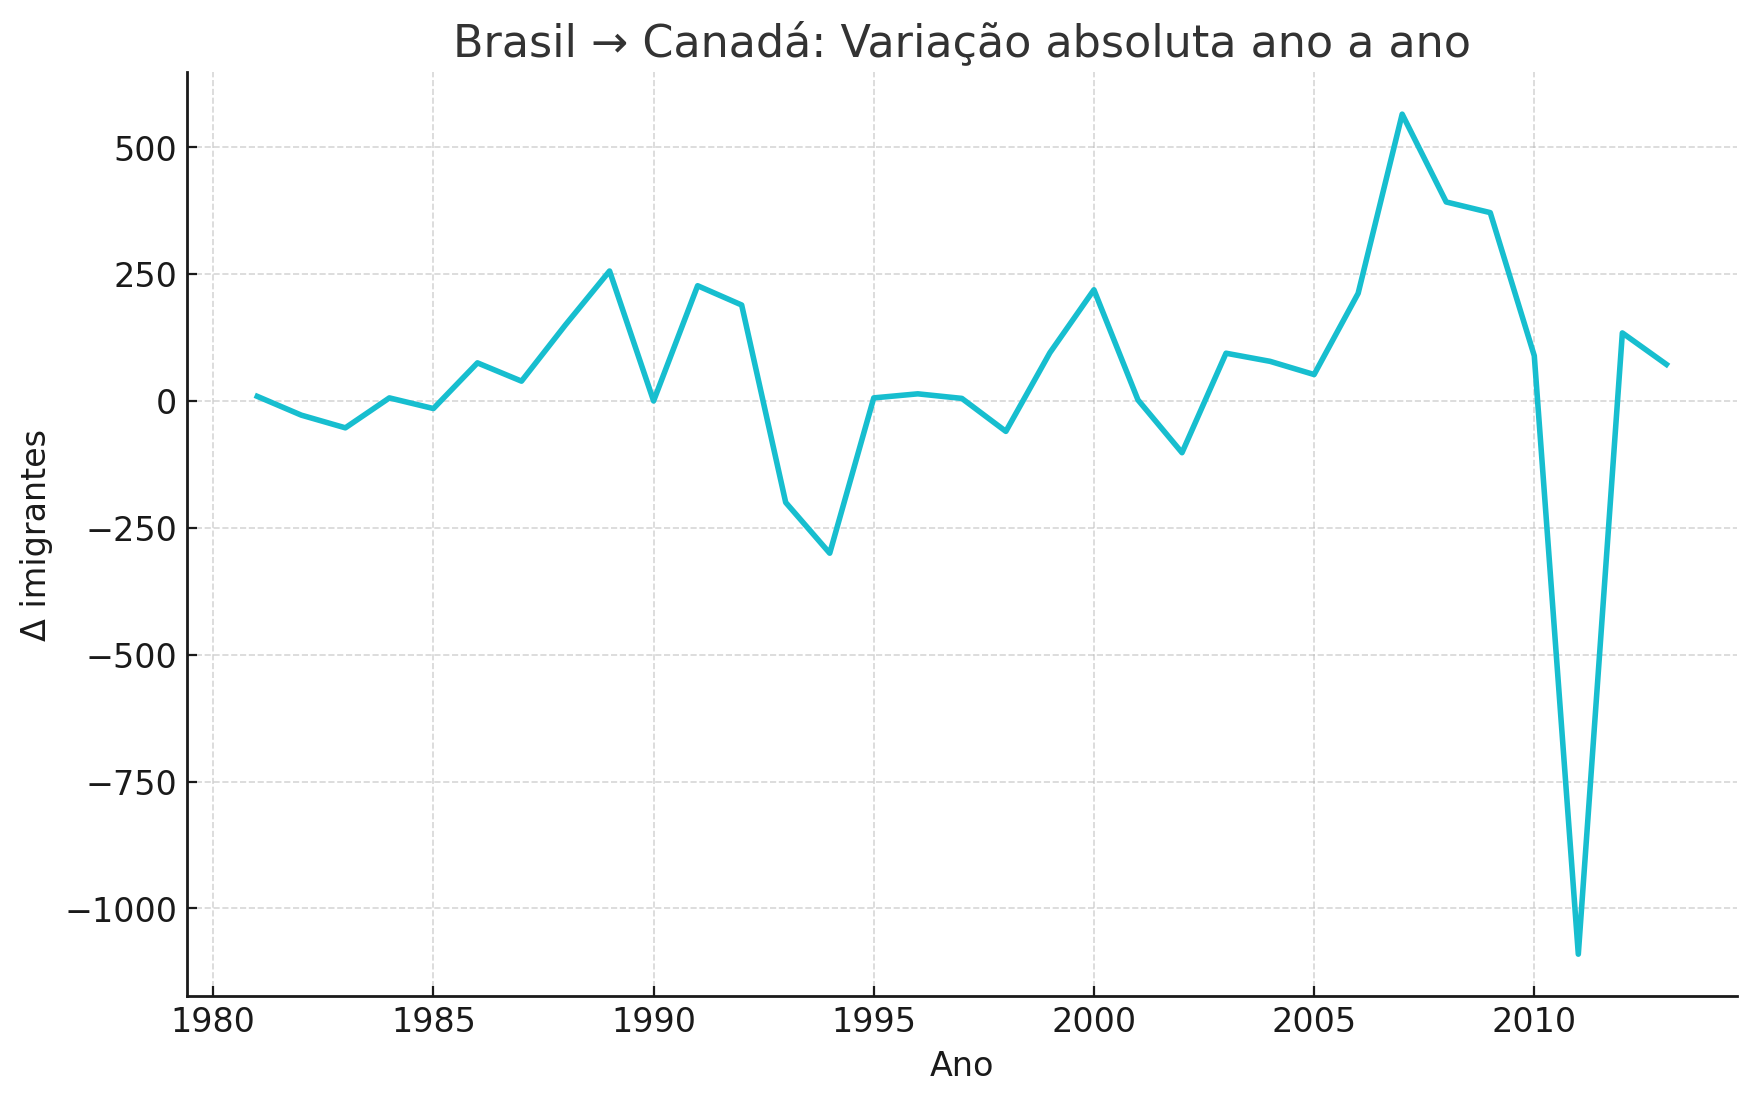

In [6]:
plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["YoY_Abs"], color=COR_YOY, linewidth=2.0)
plt.title("Brasil → Canadá: Variação absoluta ano a ano")
plt.xlabel("Ano"); plt.ylabel("Δ imigrantes"); plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(EXPORT_DIR / "02_brasil_yoy_abs.png", bbox_inches="tight")
plt.show()

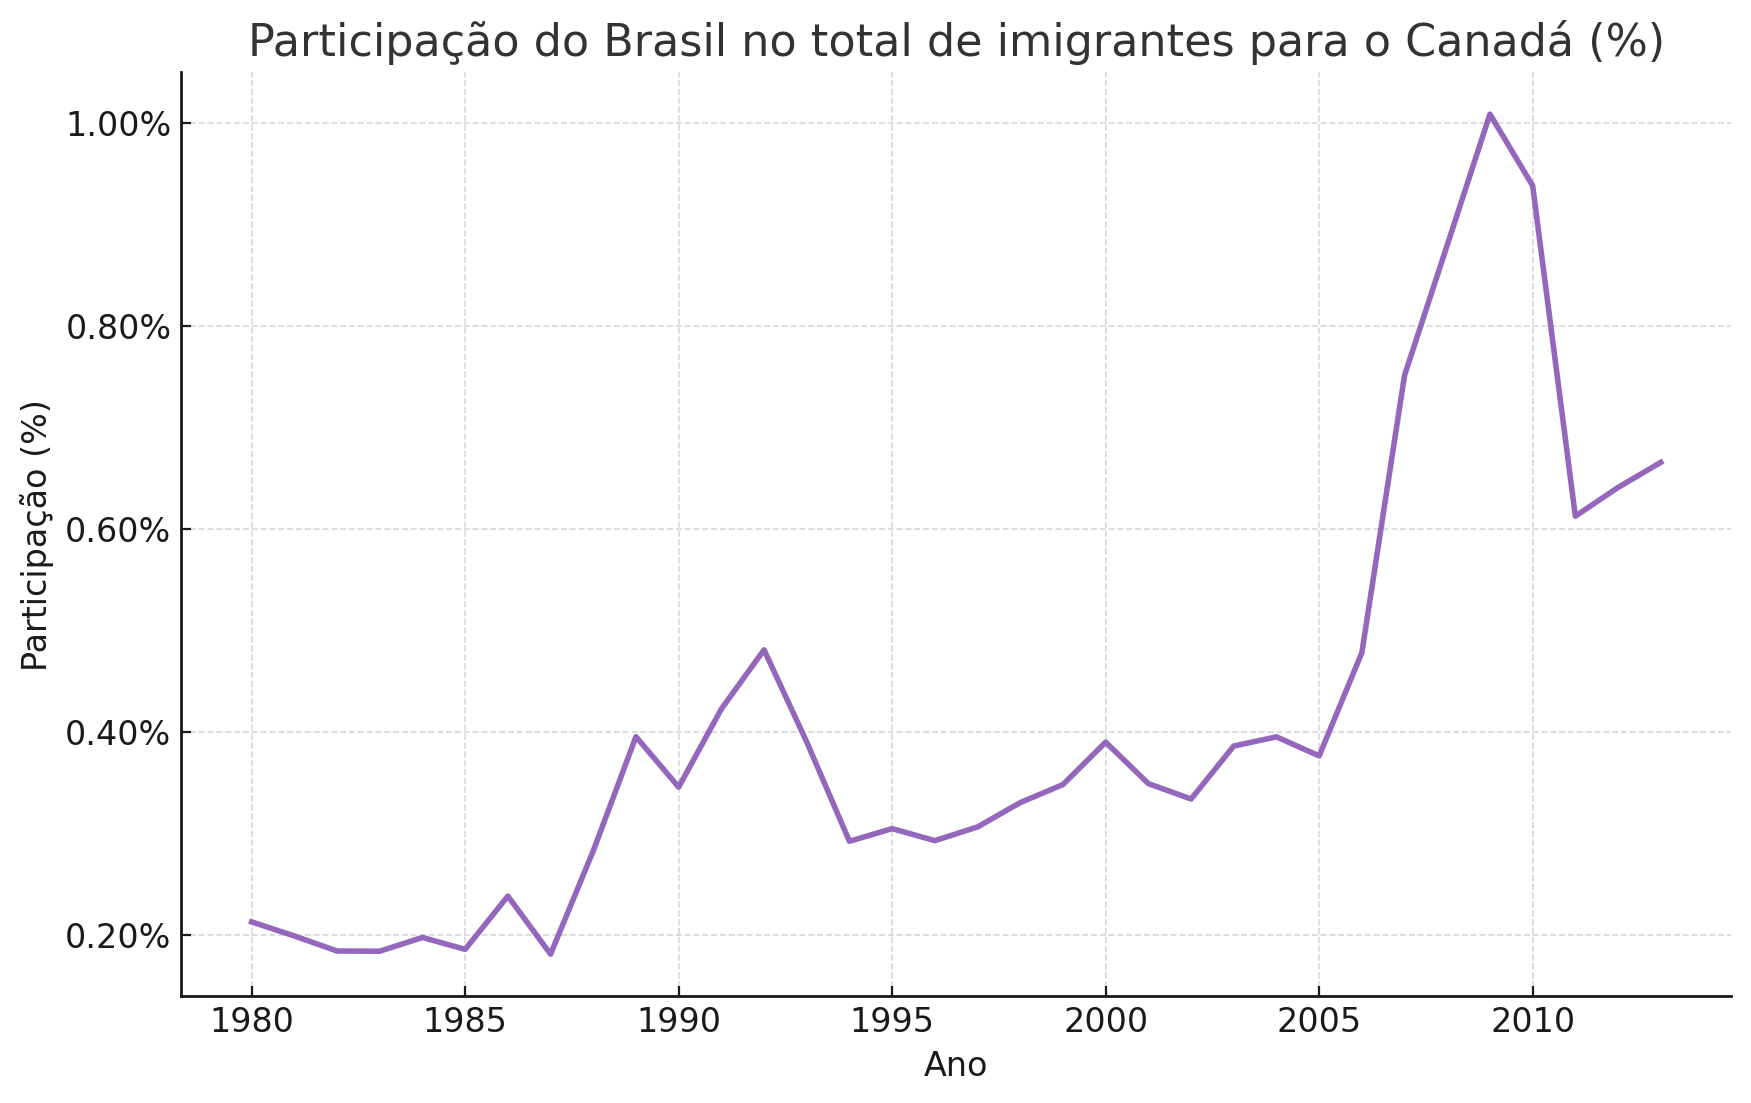

In [7]:
plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Participacao_%"], color=COR_PART, linewidth=2.0)
plt.title("Participação do Brasil no total de imigrantes para o Canadá (%)")
plt.xlabel("Ano"); plt.ylabel("Participação (%)"); plt.grid(True, linestyle="--", alpha=0.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.savefig(EXPORT_DIR / "03_brasil_participacao.png", bbox_inches="tight")
plt.show()

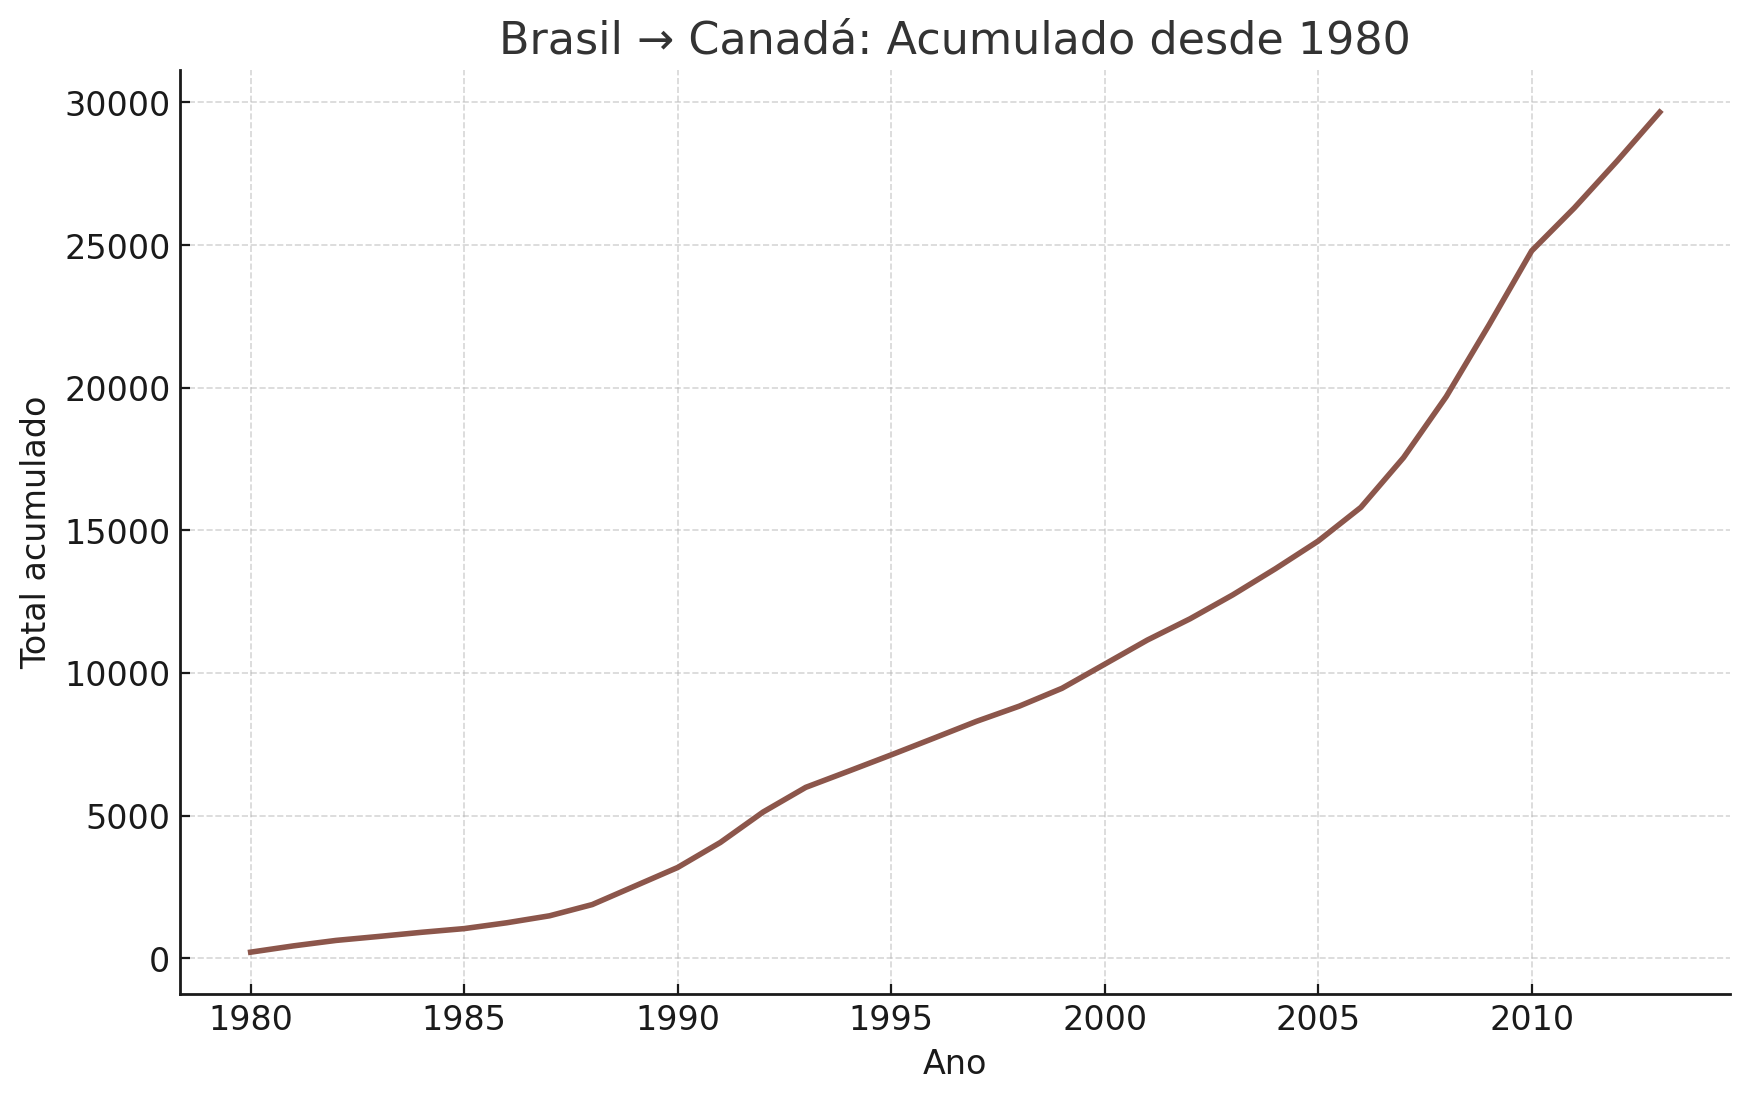

In [8]:
plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Acumulado"], color=COR_ACUM, linewidth=2.0)
plt.title("Brasil → Canadá: Acumulado desde 1980")
plt.xlabel("Ano"); plt.ylabel("Total acumulado"); plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(EXPORT_DIR / "04_brasil_acumulado.png", bbox_inches="tight")
plt.show()

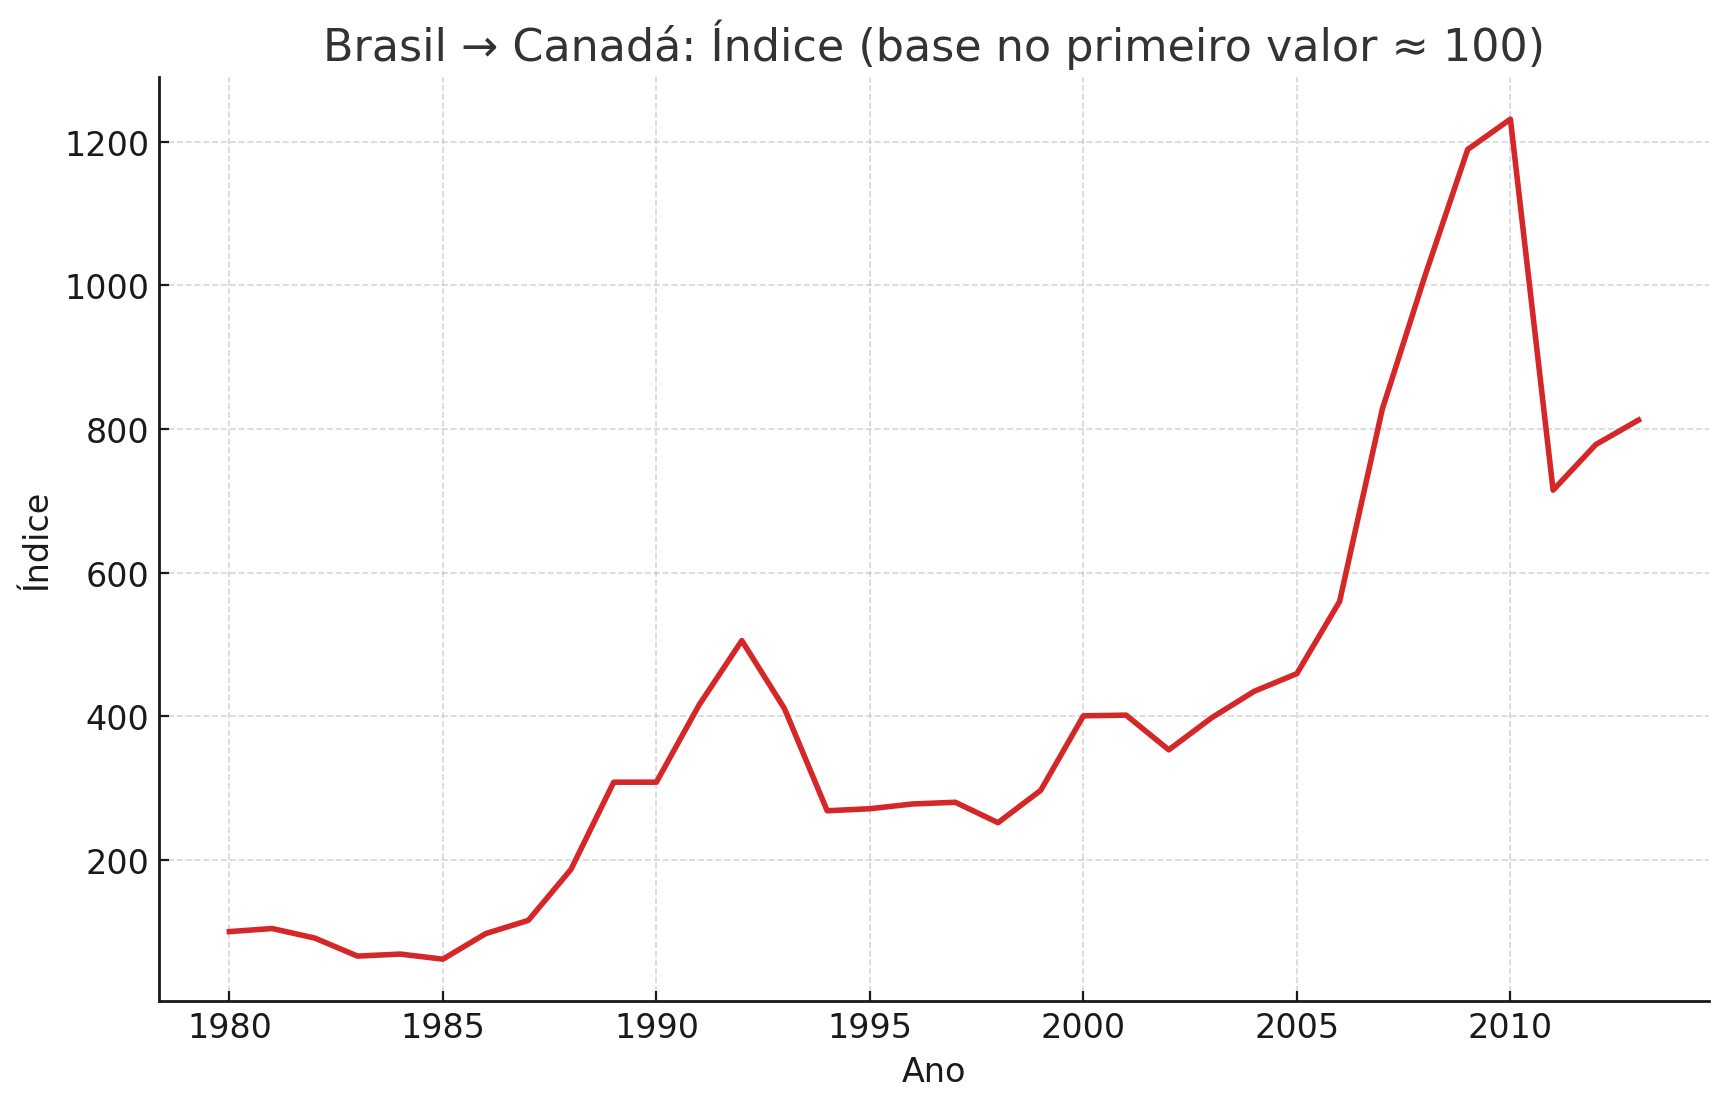

In [9]:
plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Indice_1980=100"], color=COR_INDICE, linewidth=2.0)
plt.title("Brasil → Canadá: Índice (base no primeiro valor ≈ 100)")
plt.xlabel("Ano"); plt.ylabel("Índice"); plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(EXPORT_DIR / "05_brasil_indice_base100.png", bbox_inches="tight")
plt.show()

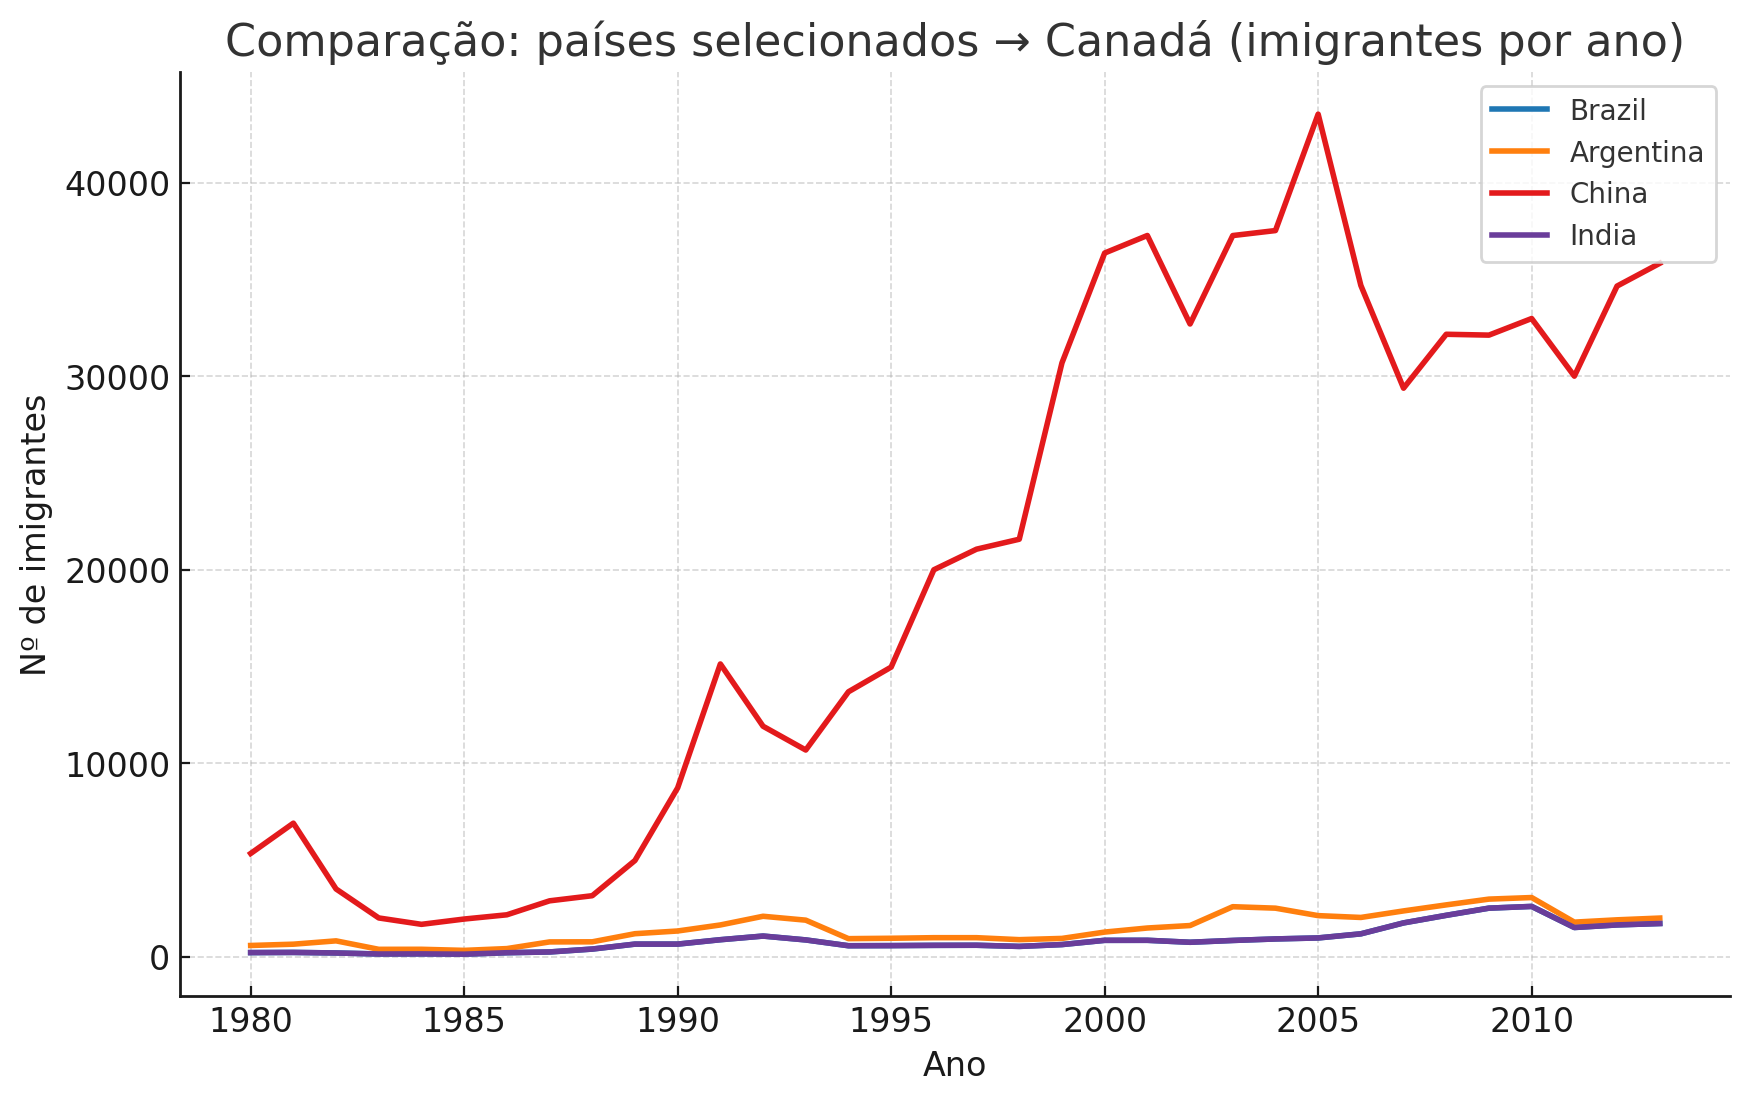

In [10]:
plt.figure()
for pais, cor in CORES_PAISES.items():
    try:
        s = obter_serie(df, country_col, year_cols, pais)
        plt.plot(s.index, s.values, label=pais, color=cor, linewidth=2.0)
    except Exception:
        pass
plt.title("Comparação: países selecionados → Canadá (imigrantes por ano)")
plt.xlabel("Ano"); plt.ylabel("Nº de imigrantes"); plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
plt.savefig(EXPORT_DIR / "06_comparacao_paises.png", bbox_inches="tight")
plt.show()

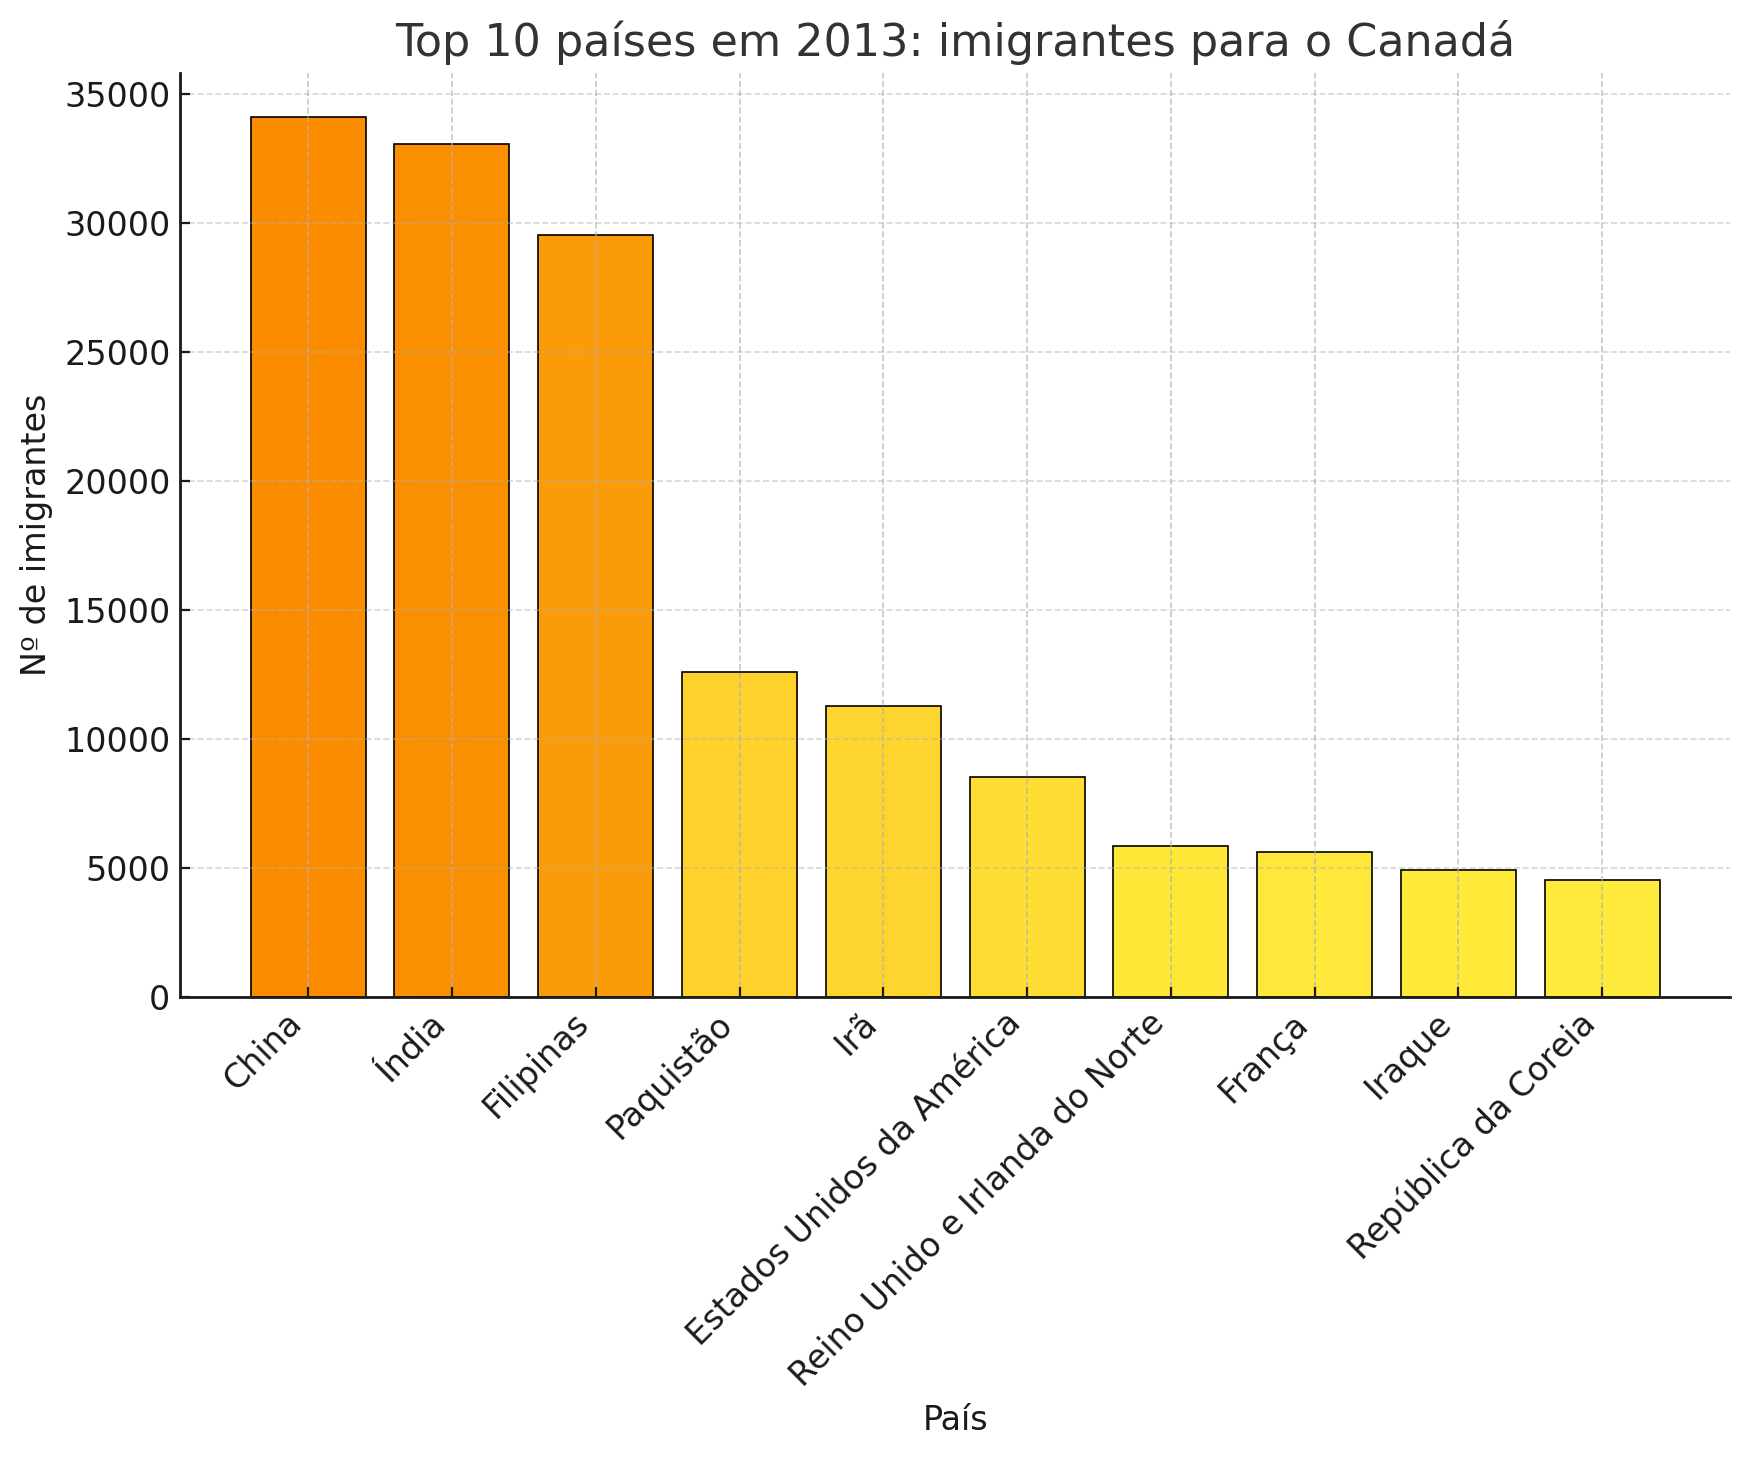

In [11]:
# Top 10 (gradiente amarelo->laranja)
ano_final = int(brazil_df["Ano"].iloc[-1]); col = str(ano_final)
tmp = df[[country_col, col]].copy(); tmp.columns = ["Pais", "Valor"]
tmp = tmp.sort_values("Valor", ascending=False).head(10)
norm = Normalize(vmin=float(tmp["Valor"].min()), vmax=float(tmp["Valor"].max()))
cmap = LinearSegmentedColormap.from_list("amarelo_laranja", ["#FFEB3B", "#FB8C00"])
cores = [cmap(norm(v)) for v in tmp["Valor"]]
plt.figure()
plt.bar(tmp["Pais"], tmp["Valor"], color=cores, edgecolor="black", linewidth=0.6)
plt.title(f"Top 10 países em {ano_final}: imigrantes para o Canadá")
plt.xlabel("País"); plt.ylabel("Nº de imigrantes"); plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.savefig(EXPORT_DIR / f"07_top10_{ano_final}_gradiente.png", bbox_inches="tight")
plt.show()

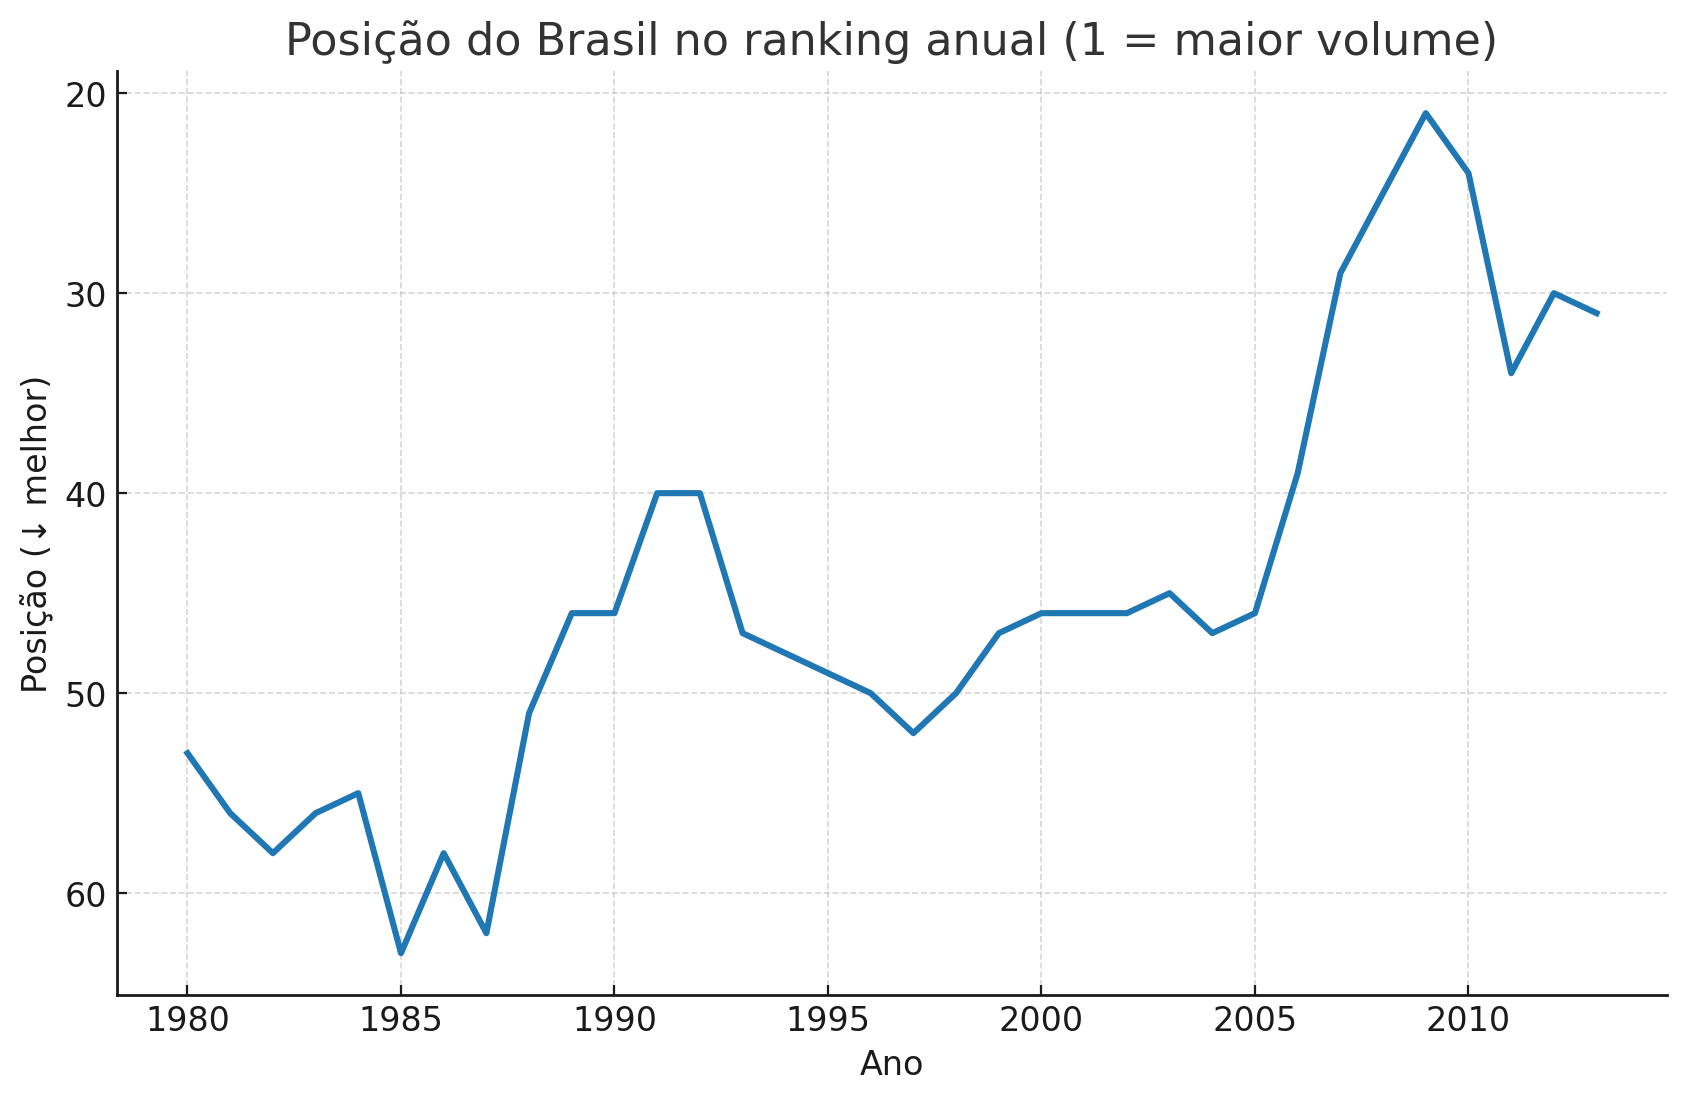

In [12]:
# Ranking anual
ranks = []
for col in year_cols:
    s = df[[country_col, col]].copy(); s.columns = ["Pais", "Valor"]
    mask_total = s["Pais"].astype(str).str.lower().str.contains("^total$|^world$", regex=True, na=False)
    s = s.loc[~mask_total]
    s["rank"] = s["Valor"].rank(ascending=False, method="min")
    rb = s.loc[s["Pais"].astype(str).str.strip().str.lower().isin(["brazil","brasil"]), "rank"]
    ranks.append(int(rb.iloc[0]) if not rb.empty else np.nan)
rank_df = pd.DataFrame({"Ano": [int(y) for y in year_cols], "Rank_Brasil": ranks}).dropna()
plt.figure()
plt.plot(rank_df["Ano"], rank_df["Rank_Brasil"], linewidth=2.2, color=COR_BRASIL)
plt.gca().invert_yaxis()
plt.title("Posição do Brasil no ranking anual (1 = maior volume)")
plt.xlabel("Ano"); plt.ylabel("Posição (↓ melhor)"); plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(EXPORT_DIR / "08_ranking_brasil.png", bbox_inches="tight")
plt.show()

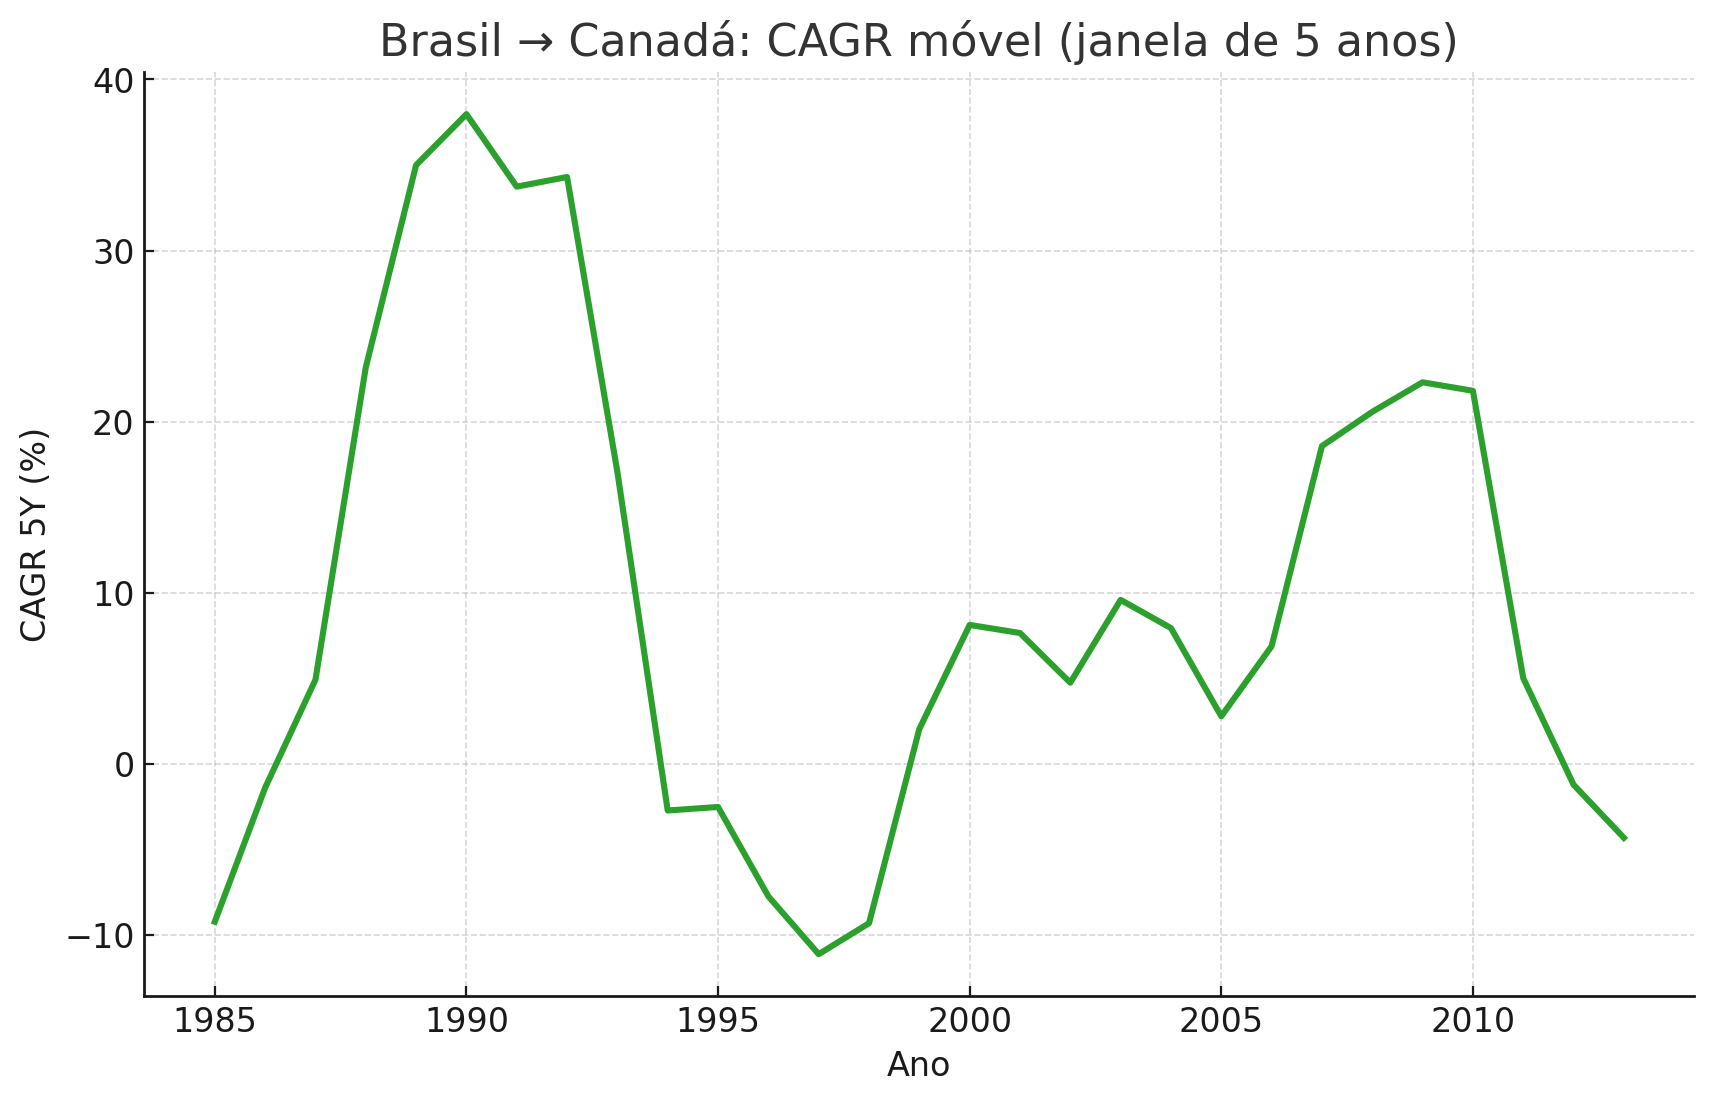

In [13]:
# CAGR 5 anos
aux = brazil_df.copy().reset_index(drop=True)
aux["CAGR_5Y"] = (aux["Imigrantes"] / aux["Imigrantes"].shift(5)) ** (1/5) - 1
plt.figure()
plt.plot(aux["Ano"], aux["CAGR_5Y"]*100, linewidth=2.2, color=COR_MM5)
plt.title("Brasil → Canadá: CAGR móvel (janela de 5 anos)")
plt.xlabel("Ano"); plt.ylabel("CAGR 5Y (%)"); plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(EXPORT_DIR / "09_cagr5_brasil.png", bbox_inches="tight")
plt.show()

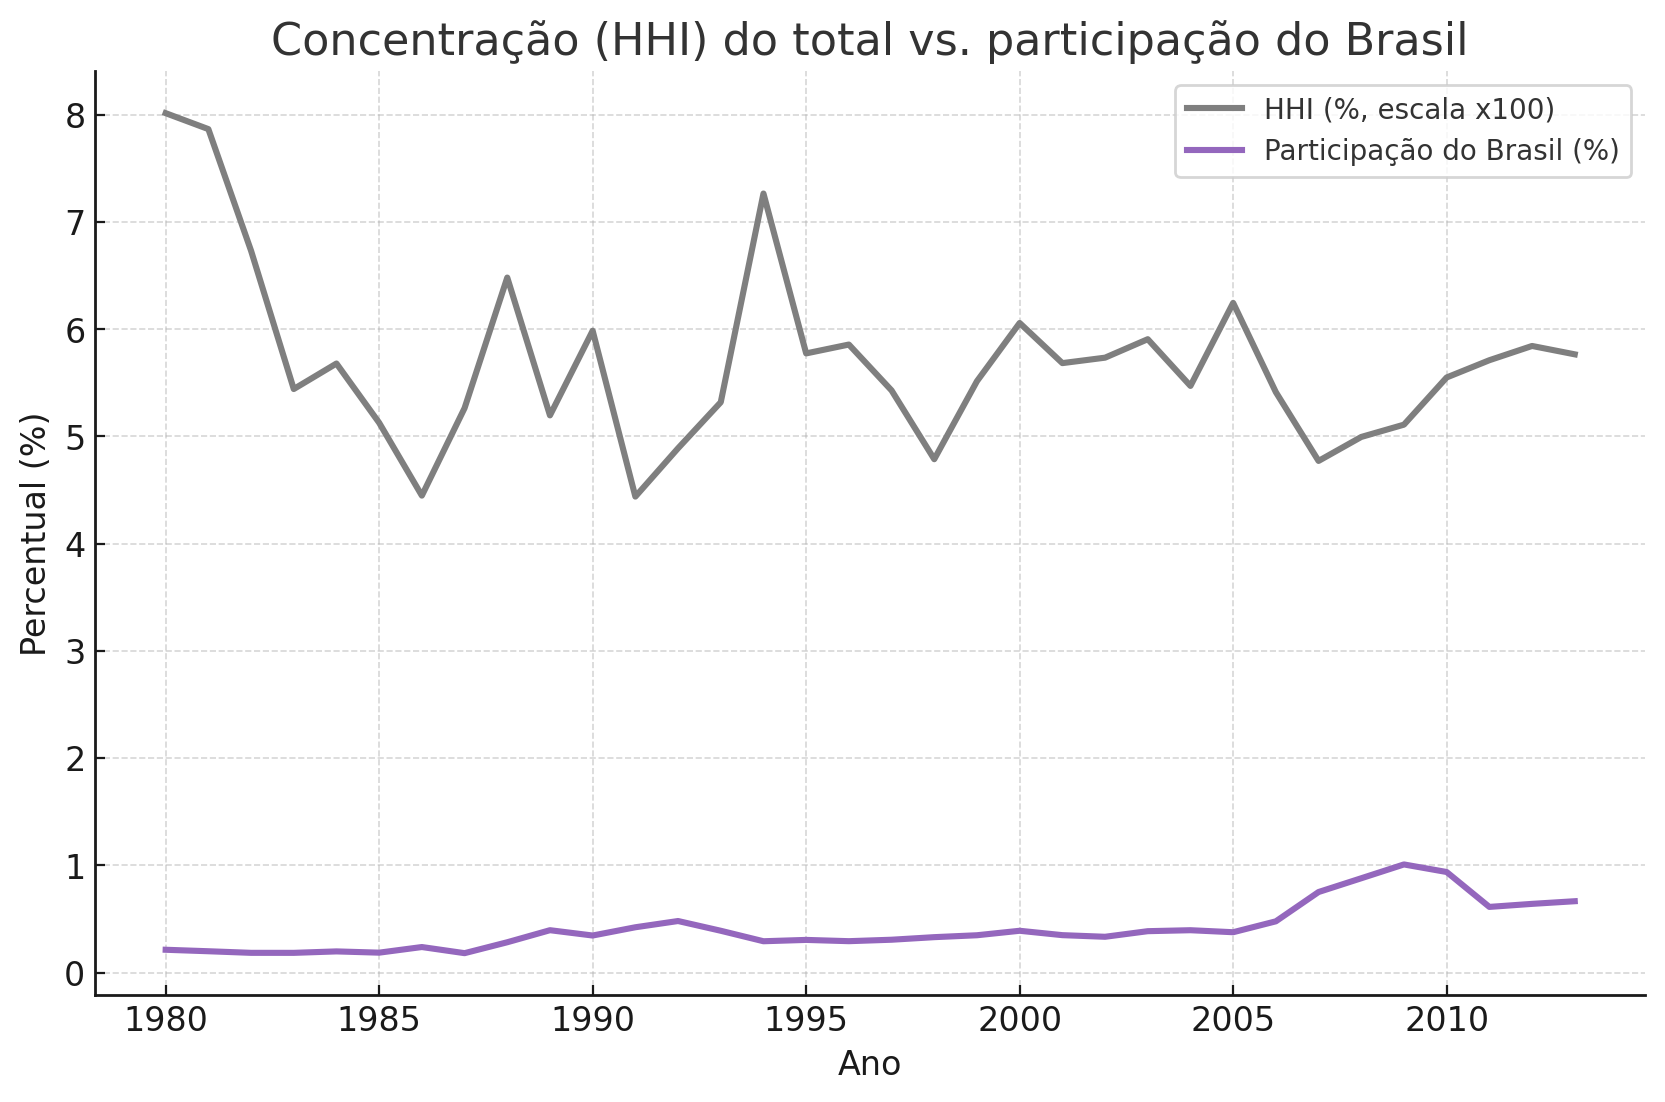

In [14]:
# HHI vs participação
mask_totalrow = df[country_col].astype(str).str.lower().str.contains("^total$|^world$", regex=True, na=False)
hhis = []; anos_calc = []
for col in year_cols:
    col_total = df.loc[~mask_totalrow, col].sum()
    shares = (df.loc[~mask_totalrow, col] / col_total).fillna(0).to_numpy()
    hhi = float(np.sum(shares**2))
    hhis.append(hhi*100); anos_calc.append(int(col))
hhi_df = pd.DataFrame({"Ano": anos_calc, "HHI_%": hhis}).sort_values("Ano")

plt.figure()
plt.plot(hhi_df["Ano"], hhi_df["HHI_%"], label="HHI (%, escala x100)", color=COR_HHI, linewidth=2.2)
plt.plot(brazil_df["Ano"], brazil_df["Participacao_%"], label="Participação do Brasil (%)", color=COR_PART, linewidth=2.2)
plt.title("Concentração (HHI) do total vs. participação do Brasil")
plt.xlabel("Ano"); plt.ylabel("Percentual (%)"); plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
plt.savefig(EXPORT_DIR / "10_hhi_vs_share.png", bbox_inches="tight")
plt.show()